# Neural Network Classification in PyTorch

Classification is one of the most fundamental tasks in supervised machine learning, where the objective is to assign input data to one or more predefined categories. Neural networks, with their ability to learn complex patterns from data, have become powerful tools for solving a wide range of classification problems across domains such as computer vision, natural language processing, and bioinformatics.

In this notebook, we focus on neural networks as **classifiers**  - models trained to distinguish between classes based on the features of the input data. While the underlying principles of training remain consistent, the nature of the classification task can vary significantly depending on the structure of the output space. Specifically, we distinguish between:

- **Binary classification**, where the model must decide between two possible classes (e.g., spam vs. not spam).
- **Multiclass classification**, where the model chooses one class from a set of more than two mutually exclusive categories (e.g., digit recognition from 0 to 9).
- **Multilabel classification**, where multiple labels may be assigned to a single input instance, allowing for overlapping classes (e.g., tagging an image as both "cat" and "outdoors").

Each of these scenarios has implications for how the neural network is structured, how the outputs are interpreted, and which loss functions and evaluation metrics are most appropriate. Throughout this notebook, we will explore these distinctions in detail, and demonstrate how to implement and train neural network classifiers tailored to each classification paradigm using PyTorch.


![Example of encoding an RGB image](https://github.com/MatteoFalcioni/PyTorch_basics/blob/main/imgs/02-different-classification-problems.png?raw=1)

## Typical Architecture of a Neural Network Classifier

| **Hyperparameter**         | **Binary Classification**                                                                 | **Multiclass Classification**                                                  |
|---------------------------|--------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------|
| **Input layer shape** (`in_features`) | Same as the number of input features (e.g., 5 for age, sex, height, weight, smoking status) | Same as binary classification                                                  |
| **Hidden layers**          | Problem-specific; minimum 1, no strict maximum                                            | Same as binary classification                                                  |
| **Neurons per hidden layer** | Typically between 10 and 512; depends on data and model complexity                        | Same as binary classification                                                  |
| **Output layer shape** (`out_features`) | 1 (to predict a probability of class 1 vs. class 0)                               | 1 per class (e.g., 3 for food, person, or dog)                                 |
| **Hidden layer activation**| Usually ReLU (`torch.nn.ReLU`), but others are possible                                   | Same as binary classification                                                  |
| **Output activation**      | Sigmoid (`torch.sigmoid`)                                                                 | Softmax (`torch.softmax`)                                                      |
| **Loss function**          | Binary Cross-Entropy (`torch.nn.BCELoss`)                                                 | Cross-Entropy (`torch.nn.CrossEntropyLoss`)                                    |
| **Optimizer**              | SGD (stochastic gradient descent), Adam (see `torch.optim` for more options)              | Same as binary classification                                                  |


## 1. Make classification data and get it ready

Let's create our own data. We are going to make a dataset of circles.

In [1]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)  # returns as y an array of 0's and 1's

In [2]:
print(f"first 5 samples of X: {X[:5]}")
print(f"first 5 samples of y: {y[:5]}")

first 5 samples of X: [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
first 5 samples of y: [1 1 1 1 0]


Labels `y` are only $0$ or $1$ --> binary classification!

### 1.1 Create a DataFrame

Let's make a pandas dataframe for clarity. `X` is bi-dimensional, so let's do:

In [3]:
# DataFrame of circle data

import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0], "X2": X[:, 1], "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


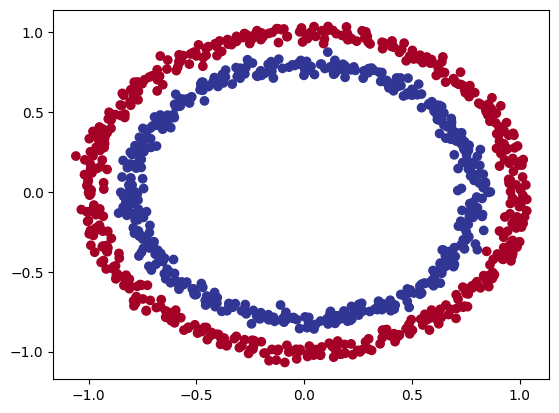

In [4]:
# How about visualizing X1 vs X2

from matplotlib import pyplot as plt
plt.scatter(x = X[:, 0],
            y = X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

Our toy dataset is composed of points belonging to 1 circle or another. Can we train our network to distinguish between red points and blue points?

Let's check data shapes

In [5]:
X.shape, y.shape

((1000, 2), (1000,))

$2$ is the number of features representing our data; in this case just $2$, but could be waaaay bigger.

In [6]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


### 1.2 Turn Data into Tensors

In [7]:
import torch

# device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

X = torch.from_numpy(X).type(torch.float) # to have torch.float32, otherwise would be torch.float64
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]


Using device: cuda


(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [8]:
X = X.to(device)
y = y.to(device)

### 1.3 Split Data into Training and Test

In [9]:
# Use sklearn to split
from sklearn.model_selection import train_test_split

# just one line in sk learn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # ordering of returns is fixed to this one

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a Classifier

In [10]:
# import torch

import torch
from torch import nn

# device agnostic (already did above, just for clarity)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


# build model class

class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(in_features=2, out_features=5)  # we want to create two linear layers so 2 -> 5
    self.layer2 = nn.Linear(in_features=5, out_features=1)  # then 5 -> 1

  # define forward() method
  def forward(self, x):
    return self.layer2(self.layer1(x))


# instantiate a model
model_0 = CircleModelV0().to(device)
model_0

Using device: cuda


CircleModelV0(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
)

In [11]:
# Let's replicate using nn.Sequential() - standard torch and just better overall

# import torch

import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()

    self.linear_layers = nn.Sequential(  # equivalent to above
        nn.Linear(in_features=2, out_features=5),
        nn.Linear(in_features=5, out_features=1)
    )

  def forward(self, x):
    return self.linear_layers(x)


# instantiate a model
model_0 = CircleModelV0().to(device)
model_0

Using device: cuda


CircleModelV0(
  (linear_layers): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): Linear(in_features=5, out_features=1, bias=True)
  )
)

In [12]:
# make some untrained predictions

with torch.inference_mode():
  untrained_preds = model_0.forward(X_test)

untrained_preds[:10]

tensor([[0.0751],
        [0.0353],
        [0.2807],
        [0.0164],
        [0.4418],
        [0.4163],
        [0.1767],
        [0.2663],
        [0.2736],
        [0.0344]], device='cuda:0')

In [13]:
# of course right now they will be wrong since we didn't train

y_test[:10]

tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0')

Notice that the outputs from our model (`untrained_preds`) are not whole numbers, and they don't directly match the ground truth labels, which are 0s and 1s in this case.

This is expected. First of all, we haven't trained the model yet, so its weights are still random. But *even in a trained model, the outputs are usually not class labels*. Instead, the model returns continuous values that we often refer to as **logits**.

In binary classification, when we apply a sigmoid activation function to the logits, we get values between 0 and 1. These can be interpreted as the model's confidence (or probability) that the input belongs to class 1. For example, a prediction of $0.72$ means the model is $72 \%$ confident the input should be classified as class 1.

In [14]:
# output = logits ---sigmoid---> probabilities
y_probs = torch.sigmoid(untrained_preds)
y_probs[:10]

tensor([[0.5188],
        [0.5088],
        [0.5697],
        [0.5041],
        [0.6087],
        [0.6026],
        [0.5441],
        [0.5662],
        [0.5680],
        [0.5086]], device='cuda:0')



To compare predictions to the ground truth, we usually apply a threshold (often $0.5$) to convert the output into a class label: values above the threshold are interpreted as class 1, and values below as class 0.





In [15]:
torch.round(y_probs)[:10]   # will be wrong (untrained)

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')


In multiclass classification, we use a softmax function instead of a sigmoid. This transforms the logits into a probability distribution across all possible classes.

So, the important point is that neural networks typically output continuous values, and we must interpret or post-process them to obtain final class predictions.

For a deeper dive, see **entropic theory of info LINK!**

So, knowing this, we should choose our loss accordingly. We basically want to aply a sigmoid layer to our outputs and then compute the loss on these probabilities. Fortunately, torch's [`nn.BCEWithLogitsLoss()`](https://docs.pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html#bcewithlogitsloss) does both steps for us: it applies a sigmoid function to our layer and then computes the *Cross Entropy Loss*.

> **Note:** There exists also a method called [`.nn.BCELoss()](`https://docs.pytorch.org/docs/stable/generated/torch.nn.BCELoss.html#bceloss), that doesn't automatically apply the sigmoid function. As a result, it is more numerically unstable and `BCEWithLogitsLoss()` should be the preferred choice.   

In [16]:
# reproducibility
torch.manual_seed(42)
# gpu reproducibility
torch.cuda.manual_seed(42)

# setup the loss function
loss_fn = nn.BCEWithLogitsLoss()

# setup optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                              lr=0.1)

> **Note:** If you're using a GPU with PyTorch and want full reproducibility, you should use both `torch.manual_seed()` `torch.cuda.manual_seed()`. `torch.manual_seed()` it may not guarantee deterministic behavior for all GPU-related functions, especially when using multiple GPUs or advanced CUDA features.

The last thing we could do is set up an evaluation metric, for example an accuracy function. It gives us the same info as the loss, but from a different perspective.

In [17]:
def accuracy_fn(y_pred, y_true):  # we could use sklearn accuracy, but let's use ours this time
  n_correct = torch.eq(y_pred, y_true).sum().item()
  acc = (n_correct / len(y_pred)) * 100
  return acc

## 3. Train Model

In [18]:
def train_model(model, X_train, X_test, y_train, y_test, epochs, optimizer, loss_fn):

  train_loss_values = []
  eval_loss_values = []
  train_accuracy_values = []
  eval_accuracy_values = []

  print_epochs = max(1, epochs // 10)  # print every 10%epochs (e.g. if 1000 -> every 100)

  for epoch in range(epochs):

    ## Training
    model.train() # 1. train mode

    logits = model(X_train).squeeze() # 2. forward pass: squeeze to remove extra `1` dimensions - this won't work unless model and data are on same device

    train_loss = loss_fn(logits, y_train) # 3. compute the loss

    optimizer.zero_grad() # 4. zero out gradients before .backward()

    train_loss.backward() # 5. backpropagation

    optimizer.step()  # 6. optimize

    # let's compute predictions by hand as well, in order to compute accuracy
    y_pred = torch.round(torch.sigmoid(logits))
    train_acc = accuracy_fn(y_pred=y_pred, y_true=y_train)

    train_loss_values.append(train_loss.detach().item())  # tensor & on gpu
    train_accuracy_values.append(train_acc)


    ## Validation
    model.eval()

    with torch.no_grad():
      eval_logits = model(X_test).squeeze()

      eval_loss = loss_fn(eval_logits, y_test)

      # since we are computing accuracy:
      y_pred_eval = torch.round(torch.sigmoid(eval_logits))
      eval_acc = accuracy_fn(y_pred=y_pred_eval, y_true=y_test)

      eval_loss_values.append(eval_loss.detach().item())
      eval_accuracy_values.append(eval_acc)

    if epoch % print_epochs == 0:
      print(f"Epoch [{epoch} / {epochs}]\ntraining loss : {train_loss.detach().item():.5f}\nvalidation loss : {eval_loss.detach().item():.5f}\ntraining accuracy: {train_acc:.5f} \nvalidation accuracy: {eval_acc:.5f}")

  return train_loss_values, eval_loss_values, train_accuracy_values, eval_accuracy_values


In [19]:
# for visualization let's use an helper function

import matplotlib.pyplot as plt

import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


In [20]:
# Let's train!

print(f"Training on device {device}")
model = CircleModelV0().to(device)

train_loss_values, eval_loss_values, train_accuracy_values, eval_accuracy_values = train_model(model=model, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, epochs=10, optimizer=optimizer, loss_fn=loss_fn)

Training on device cuda
Epoch [0 / 10]
training loss : 0.69569
validation loss : 0.69741
training accuracy: 50.00000 
validation accuracy: 50.00000
Epoch [1 / 10]
training loss : 0.69569
validation loss : 0.69741
training accuracy: 50.00000 
validation accuracy: 50.00000
Epoch [2 / 10]
training loss : 0.69569
validation loss : 0.69741
training accuracy: 50.00000 
validation accuracy: 50.00000
Epoch [3 / 10]
training loss : 0.69569
validation loss : 0.69741
training accuracy: 50.00000 
validation accuracy: 50.00000
Epoch [4 / 10]
training loss : 0.69569
validation loss : 0.69741
training accuracy: 50.00000 
validation accuracy: 50.00000
Epoch [5 / 10]
training loss : 0.69569
validation loss : 0.69741
training accuracy: 50.00000 
validation accuracy: 50.00000
Epoch [6 / 10]
training loss : 0.69569
validation loss : 0.69741
training accuracy: 50.00000 
validation accuracy: 50.00000
Epoch [7 / 10]
training loss : 0.69569
validation loss : 0.69741
training accuracy: 50.00000 
validation acc

Mmmhhhh... looks like it's not learning much... How about visualizing what it's learning?

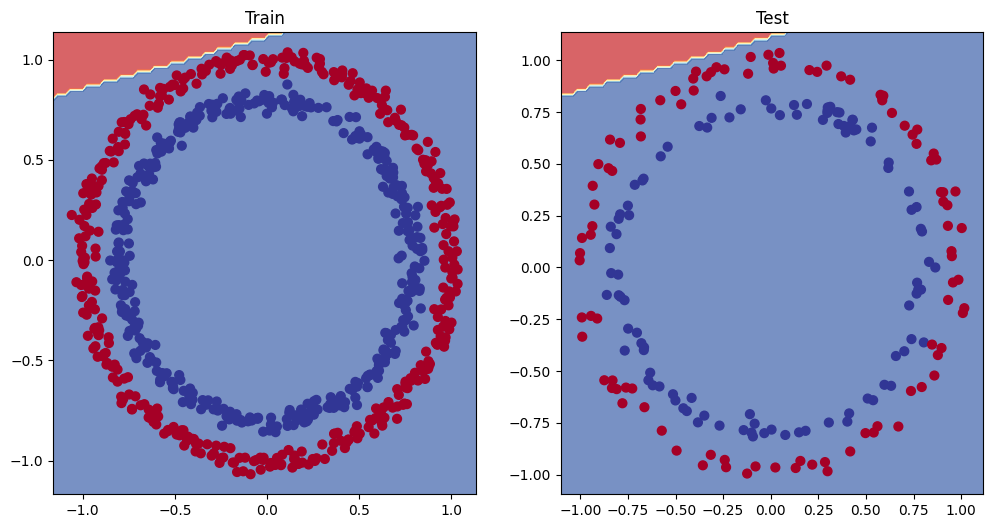

In [21]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

Alright, no wonder the loss is not decreasing. The model is learning a straight line separation between the two points. Why is that? How can we improve the model?

##5. Improve the model

In general, to try and improve the performance of a neural network, we could:

* Add more complexity to our model, by increasing the number of learned parameters. We can do this by
  - Adding more layers, giving the model more chances to learn about patterns in the data, though it may also increase the risk of overfitting and slow down training;
  - Add more "hidden units", i.e., increase the dimensions of the layers. For example, go from `nn.Linear(in_features=2, out_features=5)` to `nn.Linear(in_features=2, out_features=20)`, which allows for richer representations - but may lead to higher memory consumption and overfitting.

* Fit (train) for longer which can help improve accuracy if the model hasn’t yet converged - but be careful: may also lead to overfitting if not monitored with validation.
* Change the activation functions, as some may lead to better gradient flow or faster convergence, while others might cause issues like [vanishing or exploding gradients](https://www.geeksforgeeks.org/vanishing-and-exploding-gradients-problems-in-deep-learning/) depending on the architecture;
* Change the learning rate, since a poorly chosen value of the learning rate can either prevent the model from learning effectively or cause training to diverge;
* Try changing the optimizer, as different optimization algorithms (e.g., SGD, Adam, RMSprop) can have a significant impact on convergence speed and stability - but they may also behave differently depending on the problem and require careful tuning of their hyperparameters.
* Try different loss functions, as the choice of loss can significantly influence the optimization process—especially if it doesn’t align well with the underlying task.

As you can see, all of these options have pros and cons. Also, they are from a model perspective. Another way to improve the model could be from a data perspective - improve the data to improve the learnt representation.

Right now, let's focus on the model perspective.

In our case, our loss, learning rate and optimizer are pretty standard for this task, so they most likely are not the problem. Let's try something else then.



In [22]:
class CircleModelV1(nn.Module):

  def __init__(self):
    super().__init__()

    self.linear_layers= nn.Sequential(
        nn.Linear(in_features=2, out_features=10),  # increase hidden units
        nn.Linear(in_features=10, out_features=10), # increase the number of layers
        nn.Linear(in_features=10, out_features=1)
    )

  def forward(self, x):
    return self.linear_layers(x)

> **Note:** In actual hyperparameters experimentation, we may want to change one thing at the time, in order to see if changes have effects on the models' performances. For example, just increase the number of layers first and see.

In [23]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"using device: {device}")

# create an instance of the model
model_1 = CircleModelV1().to(device)

# define loss
loss_fn = nn.BCEWithLogitsLoss()

# create optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)  # for now let's keep same lr

# reproduciblity
torch.manual_seed(42)
torch.cuda.manual_seed(42) # Full reproducibility

# train for longer
epochs = 1000

# put data on device
X_train, y_train, X_test, y_test = X_train.to(device), y_train.to(device), X_test.to(device), y_test.to(device)

using device: cuda


Let's train!

In [24]:
train_loss_values, eval_loss_values, train_accuracy_values, eval_accuracy_values = train_model(model=model_1, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, epochs=epochs, optimizer=optimizer, loss_fn=loss_fn)

Epoch [0 / 1000]
training loss : 0.70021
validation loss : 0.70111
training accuracy: 51.50000 
validation accuracy: 53.00000
Epoch [100 / 1000]
training loss : 0.69308
validation loss : 0.69443
training accuracy: 50.25000 
validation accuracy: 48.50000
Epoch [200 / 1000]
training loss : 0.69299
validation loss : 0.69440
training accuracy: 51.00000 
validation accuracy: 47.00000
Epoch [300 / 1000]
training loss : 0.69298
validation loss : 0.69446
training accuracy: 51.50000 
validation accuracy: 46.00000
Epoch [400 / 1000]
training loss : 0.69298
validation loss : 0.69451
training accuracy: 51.50000 
validation accuracy: 45.00000
Epoch [500 / 1000]
training loss : 0.69298
validation loss : 0.69455
training accuracy: 51.37500 
validation accuracy: 45.00000
Epoch [600 / 1000]
training loss : 0.69298
validation loss : 0.69458
training accuracy: 51.25000 
validation accuracy: 45.00000
Epoch [700 / 1000]
training loss : 0.69298
validation loss : 0.69460
training accuracy: 51.12500 
validati

Damn, same thing as before!

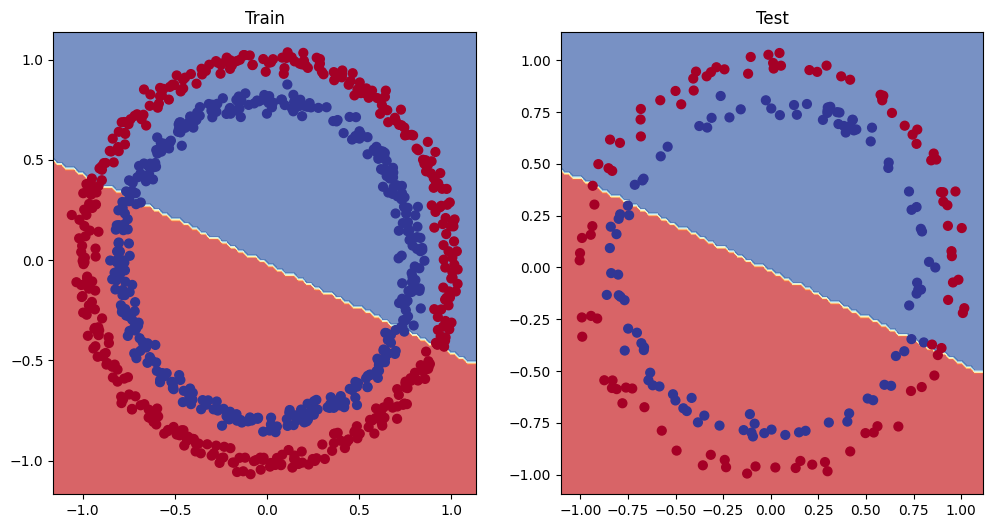

In [25]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

All right, maybe this wasn't the way to improve this specific model. Or maybe there is something deeper.

To investigate, let's see if this model can actually learn anything. How about we try it on the linear data from the earlier chapters.

### 5.1 Can our model learn a straight line?

In [26]:
# Create **linear** dataset
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1) # unsqueeze needed later on
y = weight * X + bias

# Create train/test split

train_split = int( 0.8 * len(X) )

X_train_regression, y_train_regression = X[:train_split], y[:train_split]
X_test_regression, y_test_regression = X[train_split:], y[train_split:]

In [27]:
model_try = CircleModelV1().to(device)

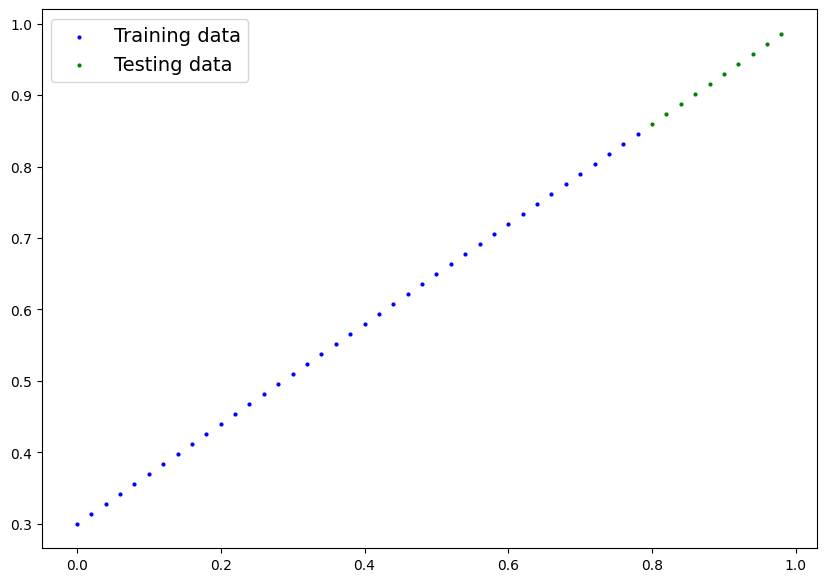

In [28]:
from helper_functions import plot_predictions

plot_predictions(X_train_regression, y_train_regression, X_test_regression, y_test_regression)

In [29]:
# put data on device
X_train_regression, y_train_regression, X_test_regression, y_test_regression = X_train_regression.to(device), y_train_regression.to(device), X_test_regression.to(device), y_test_regression.to(device)
X_test_regression.shape, X_test_regression.shape, y_train_regression.shape, y_test_regression.shape

(torch.Size([10, 1]),
 torch.Size([10, 1]),
 torch.Size([40, 1]),
 torch.Size([10, 1]))

We must be careful now: our linear data is 1D and the model expects 2D data as input. Let's change the architecture slightly:

In [30]:
# Same architecture as model_1 (but using nn.Sequential)
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [31]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.1)

In [32]:
# Train the model for linear data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data to target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
    ### Training
    # 1. Forward pass
    y_pred = model_2(X_train_regression)

    # 2. Calculate loss (no accuracy since it's a regression problem, not classification)
    loss = loss_fn(y_pred, y_train_regression)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_2.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_pred = model_2(X_test_regression)
      # 2. Calculate the loss
      test_loss = loss_fn(test_pred, y_test_regression)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss:.5f}, Test loss: {test_loss:.5f}")

Epoch: 0 | Train loss: 0.57614, Test loss: 0.47134
Epoch: 100 | Train loss: 0.09489, Test loss: 0.24818
Epoch: 200 | Train loss: 0.05440, Test loss: 0.14747
Epoch: 300 | Train loss: 0.06319, Test loss: 0.16150
Epoch: 400 | Train loss: 0.05353, Test loss: 0.13854
Epoch: 500 | Train loss: 0.06441, Test loss: 0.14258
Epoch: 600 | Train loss: 0.04558, Test loss: 0.11145
Epoch: 700 | Train loss: 0.05696, Test loss: 0.12189
Epoch: 800 | Train loss: 0.05632, Test loss: 0.11305
Epoch: 900 | Train loss: 0.05212, Test loss: 0.11977


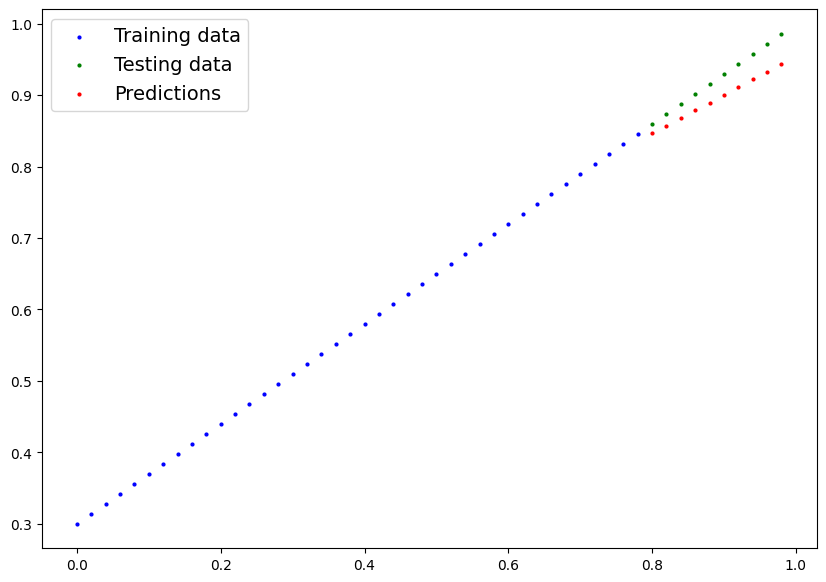

In [33]:
# Turn on evaluation mode
model_2.eval()

# Make predictions (inference)
with torch.inference_mode():
    y_preds = model_2(X_test_regression)

# Plot data and predictions with data on the CPU (matplotlib can't handle data on the GPU)
# (try removing .cpu() from one of the below and see what happens)
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu());

Alright, it looks like our model is able to do far better than random guessing on straight lines.

This is a good thing.

It means our model at least has some capacity to learn.

## 6. The missing piece: non linearity.

We've seen our model can draw straight (linear) lines, thanks to its linear layers.

But how about we give it the capacity to draw non-straight (non-linear) lines? Our missing piece is trying to use **non-linear activation functions**.

Non-linear activation functions are essential in neural networks because they allow the model to learn and represent complex, non-linear relationships in the data. *Without them, even a deep network would behave like a single-layer linear model, no matter how many layers it has* - essentially reducing the whole network to a linear transformation.

By introducing non-linearity (e.g., with functions like ReLU, Tanh, or Sigmoid), the network can approximate a wide range of functions and capture intricate patterns. In some cases, changing the activation function can significantly improve performance, especially when the existing one leads to issues like vanishing gradients or slow convergence.

In [34]:
class CircleModelV3(nn.Module):
  def __init__(self):
    super().__init__()

    self.layers = nn.Sequential(
        nn.Linear(in_features=2, out_features=10),
        nn.ReLU(), # add ReLu for non linearity
        nn.Linear(in_features=10, out_features=10),
        nn.ReLU(), # add ReLu for non linearity
        nn.Linear(in_features=10, out_features=1),

    )

  def forward(self, x):
    return self.layers(x)

> **Note:** Placing ReLU only at the end of a stack of linear layers makes the network equivalent to a single linear transformation + ReLu. Instead, to introduce non linearity ReLU is usually put in between linear layers. Also, in this way we get as output the logits as before. If we put put ReLu at the end this would output values between [$0$, $\infty$], and we'd need another normalization (for example, a sigmoid) to go back to logits.



In [35]:
# recreate the data as above for clarity

from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# Make 1000 samples
n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)  # returns as y an array of 0's and 1's

X = torch.from_numpy(X).type(torch.float) # to have torch.float32, otherwise would be torch.float64
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

X_train, X_test, y_train, y_test = X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)


Using device: cuda


In [36]:
nonlinear_model = CircleModelV3().to(device)  # instantiate model

loss_fn = nn.BCEWithLogitsLoss()  # loss

optimizer = torch.optim.SGD(params=nonlinear_model.parameters(), lr=0.1) # optimizer

In [37]:
train_loss, eval_loss, train_acc, eval_acc = train_model(nonlinear_model, X_train, X_test, y_train, y_test, epochs, optimizer, loss_fn)

Epoch [0 / 1000]
training loss : 0.69295
validation loss : 0.69319
training accuracy: 50.00000 
validation accuracy: 50.00000
Epoch [100 / 1000]
training loss : 0.69115
validation loss : 0.69102
training accuracy: 52.87500 
validation accuracy: 52.50000
Epoch [200 / 1000]
training loss : 0.68977
validation loss : 0.68940
training accuracy: 53.37500 
validation accuracy: 55.00000
Epoch [300 / 1000]
training loss : 0.68795
validation loss : 0.68723
training accuracy: 53.00000 
validation accuracy: 56.00000
Epoch [400 / 1000]
training loss : 0.68517
validation loss : 0.68411
training accuracy: 52.75000 
validation accuracy: 56.50000
Epoch [500 / 1000]
training loss : 0.68102
validation loss : 0.67941
training accuracy: 52.75000 
validation accuracy: 56.50000
Epoch [600 / 1000]
training loss : 0.67515
validation loss : 0.67285
training accuracy: 54.50000 
validation accuracy: 56.00000
Epoch [700 / 1000]
training loss : 0.66659
validation loss : 0.66322
training accuracy: 58.37500 
validati

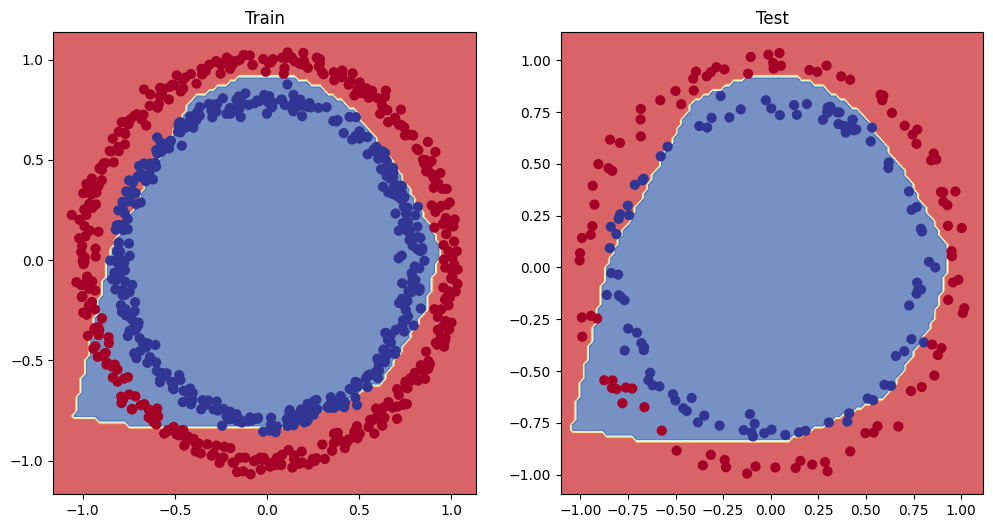

In [38]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(nonlinear_model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(nonlinear_model, X_test, y_test)

Finally! Adding non-linearity into our network allowed it to learn the more complex relation between the data. Now it is able to classify our circle points.

Let's see the losses.

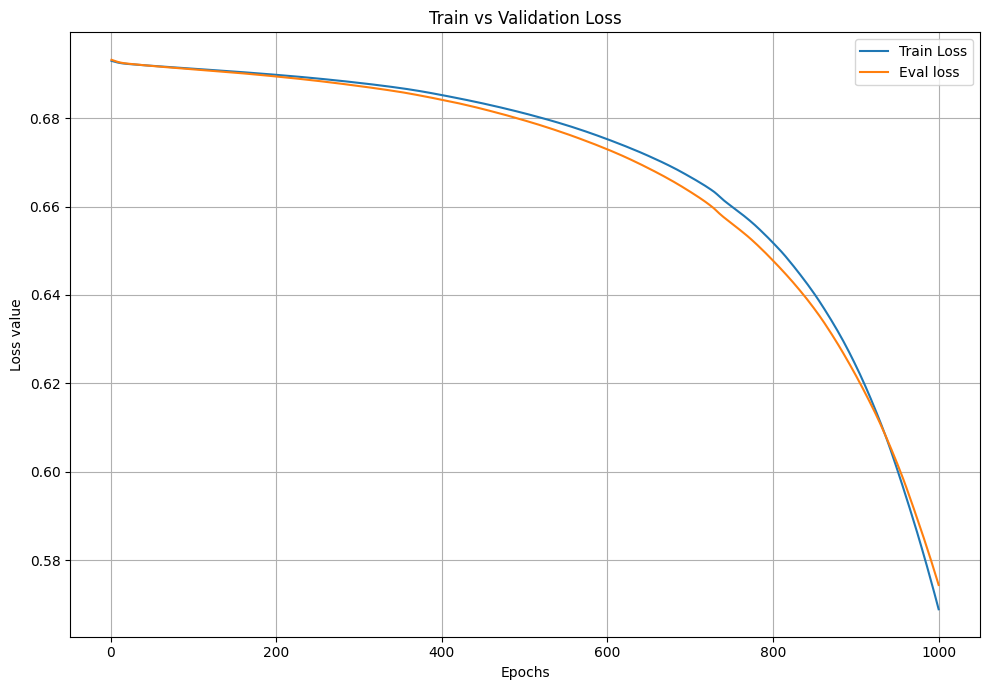

In [39]:
import matplotlib.pyplot as plt

def plot_losses(train_loss, eval_loss):

  epochs = range(1, len(train_loss) + 1)

  plt.figure(figsize=(10, 7))
  plt.plot(epochs, train_loss, label='Train Loss')
  plt.plot(epochs, eval_loss, label='Eval loss')

  plt.xlabel("Epochs")
  plt.ylabel("Loss value")

  plt.title("Train vs Validation Loss")
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()

plot_losses(train_loss, eval_loss)


We could train the model more in order to have better perfomances:

In [41]:
nonlinear_model = nonlinear_model.to(device)
train_loss, eval_loss, train_acc, eval_acc = train_model(nonlinear_model, X_train, X_test, y_train, y_test, epochs, optimizer, loss_fn)

Epoch [0 / 1000]
training loss : 0.56818
validation loss : 0.57378
training accuracy: 87.75000 
validation accuracy: 86.50000
Epoch [100 / 1000]
training loss : 0.48153
validation loss : 0.49935
training accuracy: 93.50000 
validation accuracy: 90.50000
Epoch [200 / 1000]
training loss : 0.37056
validation loss : 0.40595
training accuracy: 97.75000 
validation accuracy: 92.00000
Epoch [300 / 1000]
training loss : 0.25458
validation loss : 0.30333
training accuracy: 99.00000 
validation accuracy: 96.50000
Epoch [400 / 1000]
training loss : 0.17180
validation loss : 0.22108
training accuracy: 99.50000 
validation accuracy: 97.50000
Epoch [500 / 1000]
training loss : 0.12188
validation loss : 0.16512
training accuracy: 99.62500 
validation accuracy: 99.00000
Epoch [600 / 1000]
training loss : 0.09123
validation loss : 0.12741
training accuracy: 99.87500 
validation accuracy: 99.50000
Epoch [700 / 1000]
training loss : 0.07100
validation loss : 0.10319
training accuracy: 99.87500 
validati

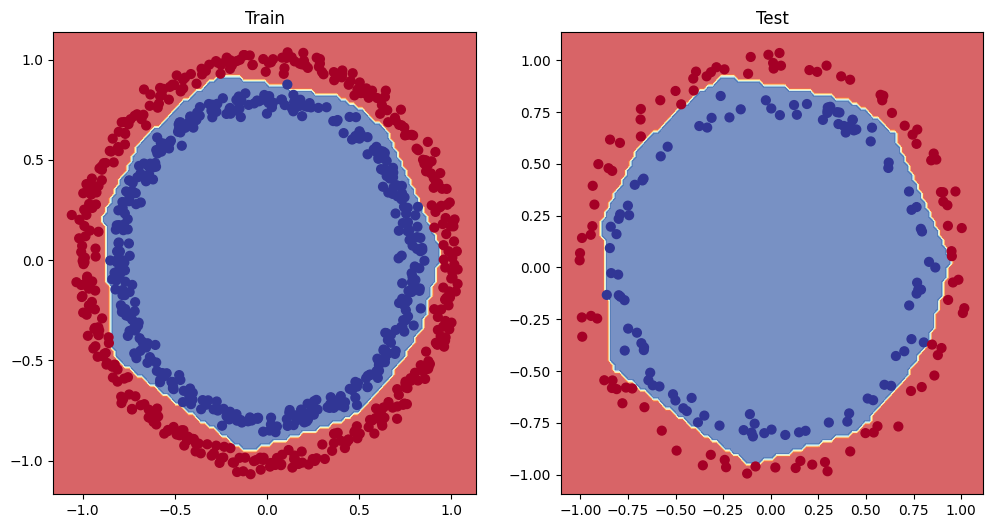

In [42]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(nonlinear_model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(nonlinear_model, X_test, y_test)

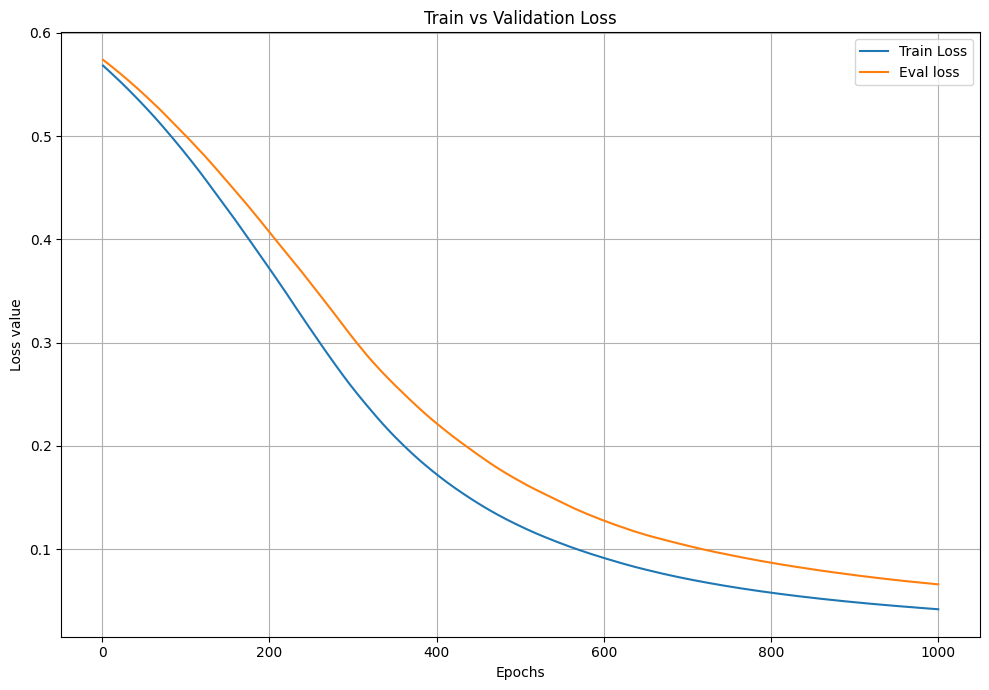

In [44]:
# wait: are we overfitting??
plot_losses(train_loss, eval_loss)  # actually these are epochs 1000 to 2000 ***

Perfect. Our model is not even overfitting, as the validation loss is still decreasing, and its accuracy is up to $99.5 \%$.